## Import all dependencies

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as DataLoader
import torchvision
import torchvision.transforms as ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.utils.data
from torchsummary import summary
from torchvision.datasets import ImageFolder
import numpy as np
import os
from PIL import Image
import graphviz
# from torchview import draw_graph
from sklearn.model_selection import train_test_split

## Download cat & dog images

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   134M      0  0:00:05  0:00:05 --:--:--  128M


In [3]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip   PetImages  'readme[1].txt'   sample_data


In [4]:
!ls PetImages

Cat  Dog


## Setting

In [5]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu or cpu

# Hyperparameters (Set some contants...)
RANDOM_SEED = 42
LEARNING_RATE = 0.001
NUM_EPOCHS = 25
BATCH_SIZE = 64
IMAGE_SIZE = (180, 180)

# Set random seeds for reproducibility
torch.manual_seed(RANDOM_SEED)

## Cats vs Dogs Dataset
Note: converting subfolders to the dataset by ImageFoldwer Function

In [6]:
image_dir = "./PetImages"
full_dataset = ImageFolder(image_dir)

In [ ]:
full_dataset

Dataset ImageFolder
    Number of datapoints: 25000
    Root location: ./PetImages

## Show custom image

In [ ]:
with Image.open(full_dataset.imgs[667][0]) as img:
    img.show()

## Creating Custom Dataset
Note: Passing the modification on the datasets

In [7]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform = None):
        self.transform = transform
        self.dataset = self.checkChannel(dataset) # some images are CMYK, Grayscale, check only RGB

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image = Image.open(self.dataset[index][0])

        if self.transform:
            images = self.transform(image)

        label = self.dataset[index][1]
        return images, label

    def checkChannel(self, dataset):
        datasetRGB = []
        for index in range(len(dataset)):
            if (os.path.getsize(dataset[index][0]) > 0):
                if ((dataset[index][0].endswith('.jpg')) and (Image.open(dataset[index][0]).getbands() == ("R", "G", "B"))):
                    datasetRGB.append(dataset[index])
        return datasetRGB

## Creating train and Test Subsets

In [8]:
raw_train_dataset, raw_test_dataset, train_label, test_label = train_test_split(full_dataset.imgs, full_dataset.targets, test_size=0.2, random_state=42)

## Passing the transforms to the train and test datasets
Note: Data augmentation and normalization for training dataset and just normalization for test dataset

In [9]:
train_transform = transforms.Compose([transforms.Resize(IMAGE_SIZE),
                                      transforms.ToTensor(),
                                      transforms.RandomRotation(degrees=20),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomVerticalFlip(p=0.005),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) # train transform

test_transform = transforms.Compose([
    transforms.Resize((180, 180)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) # test transform

train_dataset = CustomDataset(raw_train_dataset, train_transform)
test_dataset = CustomDataset(raw_test_dataset, test_transform)

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


## Dataloaders
Note: Combines a dataset and a sampler, and provides an iterable over the given dataset.

In [10]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
def show_batch(dl, invert=False):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow((data).permute(0, 2, 3, 1))
        break

show_batch(train_loader)

## Building a custom model

In [12]:
class SeperableConv2d(nn.Module):

    def __init__(self, in_channels: int, out_channels: int, *args, **kwargs):
        super().__init__()
        self.depthwise = nn.Conv2d(
            in_channels, in_channels, *args,  groups=in_channels, **kwargs)

        self.pointwise = nn.Conv2d(
            in_channels, out_channels, kernel_size = 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

In [13]:
class MinorBlock(nn.Module):
    def __init__(self, in_channel: int, out_channel: int, *args, **kwargs):
        super().__init__()

        self.bypasslayer = nn.Conv2d(in_channel, out_channel, kernel_size = 1, padding = 0, stride = 2)
        self.seperableconv1 = nn.Sequential(nn.ReLU(), SeperableConv2d(in_channel, out_channel, *args, **kwargs), nn.BatchNorm2d(out_channel), nn.ReLU())
        self.seperableconv2 = nn.Sequential(SeperableConv2d(out_channel, out_channel, *args, **kwargs), nn.BatchNorm2d(out_channel), nn.MaxPool2d(3, stride=2, padding = 1))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out1 = self.bypasslayer(x)
        out2 = self.seperableconv1(x)
        out2 = self.seperableconv2(out2)
        return out1 + out2

In [14]:
class buildingmodel(nn.Module):
    def __init__(self,num_planes: int, out_channel_firstlayer: int, num_classes: int, *args, **kwargs):
        super().__init__()

        self.first_layer = nn.Sequential(nn.Conv2d(num_planes, out_channel_firstlayer, *args, padding = 1, stride = 2), nn.BatchNorm2d(out_channel_firstlayer), nn.ReLU())
        self.minorblock_layer = []

        for input, output in zip([128, 256, 512, 728], [256, 512, 728, 1024]):
            if output !=1024:
              self.minorblock_layer.append(MinorBlock(input, output, *args, **kwargs))

        self.minorblock_layer = nn.ModuleList(self.minorblock_layer)
        self.last_layer = nn.Sequential(SeperableConv2d(728, 1024, *args, **kwargs), nn.BatchNorm2d(output), nn.ReLU(), nn.AdaptiveAvgPool2d(1))
        self.dropout = nn.Dropout(p=0.25)
        self.fullyconnected_layer = nn.Linear(output, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.first_layer(x)
        for layer in self.minorblock_layer:
            x = layer(x)
        x = self.last_layer(x)
        x = x.view(x.size(0),-1)
        x = self.dropout(x)
        x = self.fullyconnected_layer(x)
        return x


## Creating an instance model

In [15]:
model = buildingmodel(3, 128, 2, 3, padding = 1, stride = 1).to(device)

## Setting the loss function and optimizer

In [16]:
optimizer = optim.Adam(params = model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

## Visualizing the model
Note: Torchview provides visualization of models in the form of visual graphs.

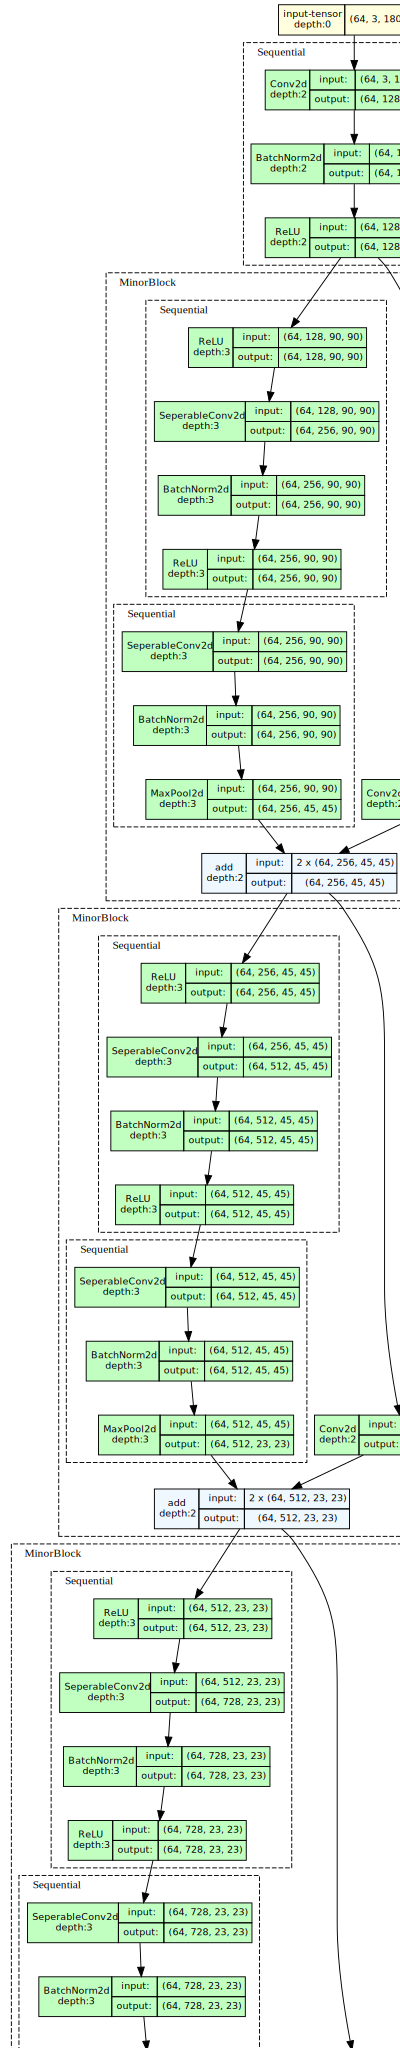

In [ ]:
model_graph = draw_graph(model, input_size = (BATCH_SIZE, 3, 180, 180), expand_nested=True) # device='meta' -> no memory is consumed for visualization
model_graph.visual_graph

Note: Torch-summary provides information complementary to what is provided by print(model) in PyTorch.

In [ ]:
summary(model, (3, 180, 180))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 90, 90]           3,584
       BatchNorm2d-2          [-1, 128, 90, 90]             256
              ReLU-3          [-1, 128, 90, 90]               0
            Conv2d-4          [-1, 256, 45, 45]          33,024
              ReLU-5          [-1, 128, 90, 90]               0
            Conv2d-6          [-1, 128, 90, 90]           1,280
            Conv2d-7          [-1, 256, 90, 90]          33,024
   SeperableConv2d-8          [-1, 256, 90, 90]               0
       BatchNorm2d-9          [-1, 256, 90, 90]             512
             ReLU-10          [-1, 256, 90, 90]               0
           Conv2d-11          [-1, 256, 90, 90]           2,560
           Conv2d-12          [-1, 256, 90, 90]          65,792
  SeperableConv2d-13          [-1, 256, 90, 90]               0
      BatchNorm2d-14          [-1, 256,

## Training loop

In [ ]:
# Training loop
train_loss_list = []
test_loss_list = []
model.train()
for epoch in range(NUM_EPOCHS):
    losses = 0
    epoch_loss = 0.0
    epoch_accuracy = 0.0

    for images, labels in train_loader:
        # push images and labels to device to get CPU support
        images = images.to(device)
        labels = labels.to(device)
        predic_labels = model(images).to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        loss = criterion(predic_labels, labels)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        losses += loss.item()

        epoch_accuracy += ((predic_labels.argmax(dim=1)==labels).float().mean())
    epoch_loss = losses / len(train_loader)

    # Test the model
    model.eval()
    with torch.no_grad():
      test_losses = 0
      epoch_test_accuracy = 0.0
      epoch_test_loss = 0.0

      for data,label in test_loader:
        data = data.to(device)
        label = label.to(device)
        predic_testlabel = model(data).to(device)
        test_loss = criterion(predic_testlabel, label)
        test_losses += test_loss.item()

        epoch_test_accuracy += ((predic_testlabel.argmax(dim=1)==label).float().mean())
    epoch_test_loss += test_losses/len(test_loader)
    ## loss data for Plot
    train_loss_list.append(epoch_loss)
    test_loss_list.append(epoch_test_loss)

    print('Epoch {}: , train accuracy: {}, train loss: {}, test_accuracy: {}, test_loss: {}'.format(epoch+1, epoch_accuracy / len(train_loader), epoch_loss, epoch_test_accuracy / len(test_loader), epoch_test_loss))


## Plot Losses of train and test data

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and test Loss")
plt.plot(test_loss_list, label="Test")
plt.plot(train_loss_list, label="Train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()